Another alternative for building time series models at scale.  Based on the research from facebook - [Prophet](https://research.fb.com/prophet-forecasting-at-scale/) - allows the user to quickly produce high quality forecasts with the ability to adjust multiple parameters.
Initial code modeled after Digital Ocean's [tutorial](https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-prophet-in-python-3).



In [1]:
!pip install fbprophet

In [0]:
import timeit

In [0]:
%matplotlib inline
import pandas as pd
from fbprophet import Prophet
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [4]:
# OBTAIN

zipcode1 = pd.read_csv('https://raw.githubusercontent.com/jaymahapatra/IST-718-Lab-6/master/zipcode1.csv', sep=',', error_bad_lines=False, encoding = "ISO-8859-1")
zipcode2 = pd.read_csv('https://raw.githubusercontent.com/jaymahapatra/IST-718-Lab-6/master/zipcode2.csv', sep=',', error_bad_lines=False, encoding = "ISO-8859-1")
zipcode=zipcode1.append(zipcode2)
zipcode.head()

#Drop Columns
zipcode = zipcode.drop(columns=['1996-04','1996-05','1996-06','1996-07','1996-08','1996-09','1996-10','1996-11','1996-12'])
zipcode.head()

#Create Little Rock/Hot Springs/Fayetteville/Searcy only Pandas Data frame
ark = (zipcode.loc[zipcode['City'].isin(['Hot Springs','Little Rock','Fayetteville','Searcy'])])
ark1 = (ark.loc[ark['State'].isin(['AR'])])
ark1


hot = (ark1.loc[ark1['City'].isin(['Hot Springs'])])
hot
lit = (ark1.loc[ark1['City'].isin(['Little Rock'])])
lit
fay = (ark1.loc[ark1['City'].isin(['Fayetteville'])])
fay
sea = (ark1.loc[ark1['City'].isin(['Searcy'])])
sea

#spri = (zipcode.loc[zipcode['RegionName'].isin(['92677'])])
#spri


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1997-01,1997-02,1997-03,...,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12
2264,89409,72143,Searcy,AR,Searcy,White County,2265,76400.0,76700.0,77000.0,...,125600,126200,126500,126500,126400,126000,126400,128100,130400,131700


In [5]:
## SOME BASIC TIME DF MANIPULATION

# remove unwanted cols
# df = df.drop(columns = ['RegionID','City','State','Metro','CountyName','SizeRank'])
# convert zip code to col names
# df = df.set_index('ZipCode')
# transpose time series matrices
# df = df.T
# convert indices to date time
# df.index = pd.to_datetime(df.index)
# df.head()

# remove unwanted cols
hot = hot.drop(columns = ['RegionID','RegionName','State','Metro','CountyName','SizeRank'])
# convert zip code to col names
hot = hot.set_index('City')
# transpose time series matrices
hot = hot.T
# convert indices to date time
hot.index = pd.to_datetime(hot.index)
hot.columns = ['HotSprings1','HotSprings2']
hot["Hot Springs3"] = (hot['HotSprings1'] + hot['HotSprings2'])/2
hot=hot.drop(columns=['HotSprings1', 'HotSprings2'])
hot

# remove unwanted cols
lit = lit.drop(columns = ['RegionID','RegionName','State','Metro','CountyName','SizeRank'])
# convert zip code to col names
lit = lit.set_index('City')
# transpose time series matrices
lit = lit.T
# convert indices to date time
lit.index = pd.to_datetime(lit.index)
lit.columns = ['Lit1','Lit2','Lit3','Lit4','Lit5','Lit6','Lit7']
lit['Little Rock'] = (lit['Lit1'] + lit['Lit2'] +lit['Lit3'] + lit['Lit4'] +lit['Lit5'] + lit['Lit6'] + lit['Lit7'])/7
lit=lit.drop(columns=['Lit1','Lit2','Lit3','Lit4','Lit5','Lit6','Lit7'])
lit

# remove unwanted cols
fay = fay.drop(columns = ['RegionID','RegionName','State','Metro','CountyName','SizeRank'])
# convert zip code to col names
fay = fay.set_index('City')
# transpose time series matrices
fay = fay.T
# convert indices to date time
fay.index = pd.to_datetime(fay.index)
fay.columns = ['Fay1','Fay2','Fay3']
fay['Fayetteville'] = (fay['Fay1'] + fay['Fay2'] +fay['Fay3'])/3
fay=fay.drop(columns=['Fay1','Fay2','Fay3'])
fay

# remove unwanted cols
sea = sea.drop(columns = ['RegionID','RegionName','State','Metro','CountyName','SizeRank'])
# convert zip code to col names
sea = sea.set_index('City')
# transpose time series matrices
sea = sea.T
# convert indices to date time
sea.index = pd.to_datetime(sea.index)
sea

sea['Fayetteville'] = fay['Fayetteville']
sea['Little Rock'] = lit['Little Rock']
sea['Hot Springs'] = hot["Hot Springs3"]
ark2 = sea
ark2.head()



City,Searcy,Fayetteville,Little Rock,Hot Springs
1997-01-01,76400.0,92966.666667,126200.000000,73100.0
1997-02-01,76700.0,93466.666667,126800.000000,72950.0
1997-03-01,77000.0,93866.666667,127457.142857,72900.0
1997-04-01,77300.0,94233.333333,128142.857143,73000.0
1997-05-01,77500.0,94366.666667,128757.142857,73200.0


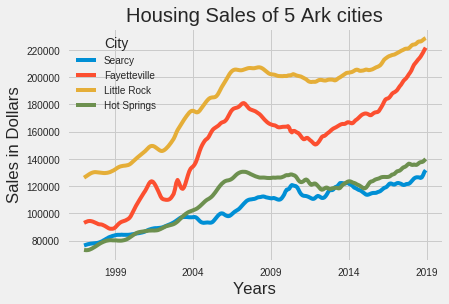

In [6]:
#plot sales of 5 Ark cities
#ark2 = ark2.cumsum()
ark2.plot()
plt.title('Housing Sales of 5 Ark cities')
plt.xlabel('Years')
plt.ylabel('Sales in Dollars')
plt.show()

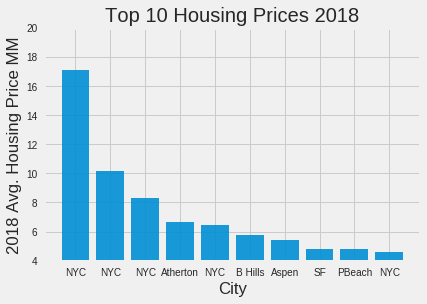

In [7]:
#Current Housing prices by Zip Code
zipcodecurrent = zipcode[['RegionName','City','State','Metro','CountyName','SizeRank','2018-12']].copy()
zipcodecurrent = zipcodecurrent.sort_values(by='2018-12',ascending=[0])
ziptop=zipcodecurrent.head(10)

#Graph Top 10 housing prices 2018
objects = ('NYC', 'NYC', 'NYC', 'Atherton', 'NYC', 'B Hills','Aspen','SF','PBeach','NYC')
y_pos = np.arange(len(objects))
performance = ziptop['2018-12']/1000000
plt.bar(y_pos, performance, align='center', alpha= .9)
plt.xticks(y_pos, objects)
plt.ylabel('2018 Avg. Housing Price MM')
plt.xlabel('City')
plt.title('Top 10 Housing Prices 2018')
plt.ylim(4,20)
plt.show()




      RegionName          City State                           Metro  \
690        19146  Philadelphia    PA  Philadelphia-Camden-Wilmington   
1159       11222      New York    NY     New York-Newark-Jersey City   
104        11211      New York    NY     New York-Newark-Jersey City   
476        11216      New York    NY     New York-Newark-Jersey City   
5193       11930    Amagansett    NY     New York-Newark-Jersey City   
167         7302   Jersey City    NJ     New York-Newark-Jersey City   
7528       11975     Wainscott    NY     New York-Newark-Jersey City   
105        11215      New York    NY     New York-Newark-Jersey City   
1837       90291   Los Angeles    CA  Los Angeles-Long Beach-Anaheim   
3561       19125  Philadelphia    PA  Philadelphia-Camden-Wilmington   

               CountyName  SizeRank   1997-01  2018-12     change  
690   Philadelphia County       691   21400.0   334400  14.626168  
1159         Kings County      1160  146600.0  1714700  10.696453  
104

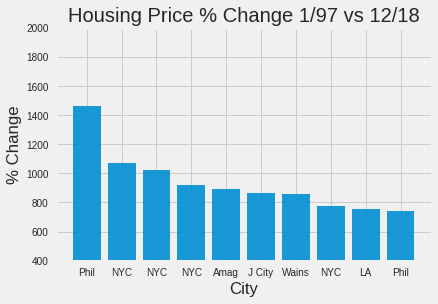

In [67]:
#Percent Change In Housing Prices Long Term
pchange = zipcode[['RegionName','City','State','Metro','CountyName','SizeRank','1997-01','2018-12']].copy()
pchange['change'] = ((pchange['2018-12']-pchange['1997-01'])/pchange['1997-01'])
pchange = pchange.sort_values(by='change',ascending=[0])
pchange.head(10)
ptop=pchange.head(10)
print(ptop)

#Graph Top 10 housing prices percent change long term
objects = ('Phil', 'NYC', 'NYC', 'NYC', 'Amag', 'J City','Wains','NYC','LA','Phil')
y_pos = np.arange(len(objects))
performance = ptop['change']*100
plt.bar(y_pos, performance, align='center', alpha= .9)
plt.xticks(y_pos, objects)
plt.ylabel('% Change')
plt.xlabel('City')
plt.title('Housing Price % Change 1/97 vs 12/18')
plt.ylim(400,2000)
plt.show()


      RegionName             City State                       Metro  \
3198       31601         Valdosta    GA                    Valdosta   
6375       31217            Macon    GA           Macon-Bibb County   
4708       31906         Columbus    GA                    Columbus   
6930       71851  Mineral Springs    AR                         NaN   
5907       77702         Beaumont    TX        Beaumont-Port Arthur   
5806       71836          Foreman    AR                   Texarkana   
433        77703         Beaumont    TX        Beaumont-Port Arthur   
5322        8611          Trenton    NJ                     Trenton   
4479       29055      Great Falls    SC  Charlotte-Concord-Gastonia   
325        21215        Baltimore    MD   Baltimore-Columbia-Towson   

               CountyName  SizeRank  2017-12  2018-12    change  
3198       Lowndes County      3199    44200    64000  0.447964  
6375          Bibb County      6376    31400    45200  0.439490  
4708      Muscogee C

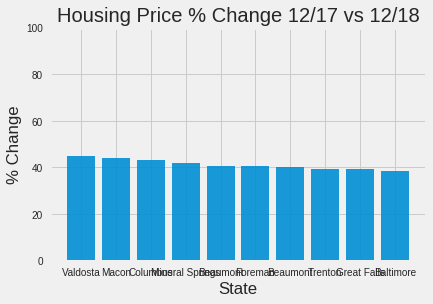

In [29]:
#Percent Change In Housing Prices Mid Term
pchange = zipcode[['RegionName','City','State','Metro','CountyName','SizeRank','2017-12','2018-12']].copy()
pchange['change'] = ((pchange['2018-12']-pchange['2017-12'])/pchange['2017-12'])
pchange = pchange.sort_values(by='change',ascending=[0])
pchange.head(10)
ptop=pchange.head(10)
print(ptop.head(10))

#Graph Top 10 housing prices percent change mid term
objects = ('Valdosta', 'Macon', 'Columbus', 'Mineral Springs', 'Beaumont', 'Foreman','Beaumont','Trenton','Great Falls','Baltimore')
y_pos = np.arange(len(objects))
performance = ptop['change']*100
plt.bar(y_pos, performance, align='center', alpha= .9)
plt.xticks(y_pos, objects)
plt.ylabel('% Change')
plt.xlabel('State')
plt.title('Housing Price % Change 12/17 vs 12/18')
plt.ylim(0,100)
plt.show()

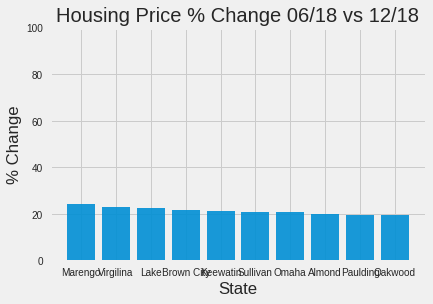

In [16]:
#Percent Change In Housing Prices Short Term
pchange = zipcode[['RegionName','City','State','Metro','CountyName','SizeRank','2018-06','2018-12']].copy()
pchange['change'] = ((pchange['2018-12']-pchange['2018-06'])/pchange['2018-06'])
pchange = pchange.sort_values(by='change',ascending=[0])
pchange.head(10)
ptop=pchange.head(10)
ptop

#Graph Top 10 housing prices percent change short term
objects = ('Marengo', 'Virgilina', 'Lake', 'Brown City', 'Keewatin', 'Sullivan','Omaha','Almond','Paulding','Oakwood')
y_pos = np.arange(len(objects))
performance = ptop['change']*100
plt.bar(y_pos, performance, align='center', alpha= .9)
plt.xticks(y_pos, objects)
plt.ylabel('% Change')
plt.xlabel('State')
plt.title('Housing Price % Change 06/18 vs 12/18')
plt.ylim(0,100)
plt.show()

In [21]:
from scipy.stats import uniform  # for training-and-test split
import statsmodels.api as sm  # statistical models (including regression)
import statsmodels.formula.api as smf  # R-like model specification

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [22]:
#Load in US Cities population data
#https://simplemaps.com/data/us-cities
population2013 = pd.read_csv('https://raw.githubusercontent.com/jaymahapatra/IST-718-Lab-6/master/gistfile1.csv', sep=',', error_bad_lines=False, encoding = "ISO-8859-1")
population2013.rename(columns={'city':'City'}, inplace=True)
population2013.rename(columns={'2000-2013 growth':'growth'}, inplace=True)
poptest = (pd.merge(zipcode, population2013, on='City'))
poptest
poptest1 = poptest[['RegionName','City','State','SizeRank','population','2000-12','2013-12','growth']]
poptest1 = poptest1.dropna()
poptest1.head(25)
poptest1.describe()
poptest1['saleschange'] = ((poptest['2013-12']-poptest['2000-12'])/poptest['2000-12'])
poptest1.columns = ['RegionName','City','State','sizerank','population','dectwothousand','dectwothousandthirteen','growth','saleschange']
poptest1 = poptest1.groupby('City').mean()
poptest1


,RegionName,sizerank,population,dectwothousand,dectwothousandthirteen,growth,saleschange
City,,,,,,,
Abilene,77571.166667,5083.000000,120099.000000,73150.000000,99016.666667,0.040000,0.339694
Addison,50726.250000,8147.250000,37385.000000,144325.000000,172025.000000,0.030000,0.292024
Akron,41888.100000,6488.800000,198100.000000,87800.000000,77890.000000,-0.090000,-0.162983
Alameda,94501.500000,3863.500000,76419.000000,409750.000000,664200.000000,0.050000,0.618827
Albany,42453.357143,6370.928571,75397.333333,123385.714286,182085.714286,0.096667,0.385392
Albuquerque,87112.133333,2396.733333,556495.000000,137900.000000,183673.333333,0.240000,0.314972
Alexandria,44217.333333,8345.166667,98659.000000,93016.666667,120833.333333,0.095000,0.364179
Alhambra,81868.333333,6542.333333,84577.000000,190200.000000,408100.000000,-0.010000,0.986003
Aliso Viejo,92656.000000,705.000000,50175.000000,362100.000000,687400.000000,0.250000,0.898371


In [23]:
#Build A Model
# employ training-and-test regimen for model validation
np.random.seed(1234)
poptest1['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(poptest1))
poptest1_train = poptest1[poptest1['runiform'] >= 0.33]
poptest1_test = poptest1[poptest1['runiform'] < 0.33]
# check training data frame
print('\final_train data frame (rows, columns): ',poptest1_train.shape)
print(poptest1_train.head())
# check test data frame
print('\final_test data frame (rows, columns): ',poptest1_test.shape)
print(poptest1_test.head())

inal_train data frame (rows, columns):  (597, 8)
            RegionName     sizerank     population  dectwothousand  \
City                                                                 
Addison   50726.250000  8147.250000   37385.000000   144325.000000   
Akron     41888.100000  6488.800000  198100.000000    87800.000000   
Alameda   94501.500000  3863.500000   76419.000000   409750.000000   
Albany    42453.357143  6370.928571   75397.333333   123385.714286   
Alhambra  81868.333333  6542.333333   84577.000000   190200.000000   

          dectwothousandthirteen    growth  saleschange  runiform  
City                                                               
Addison            172025.000000  0.030000     0.292024  0.622109  
Akron               77890.000000 -0.090000    -0.162983  0.437728  
Alameda            664200.000000  0.050000     0.618827  0.785359  
Albany             182085.714286  0.096667     0.385392  0.779976  
Alhambra           408100.000000 -0.010000     0.98

In [24]:
# specify a simple model that factors in capacity overall win percentage and conference
my_model = str('dectwothousandthirteen ~ growth + population + saleschange')

# fit the model to the training set
train_model_fit = smf.ols(my_model, data = poptest1_train).fit()
# summary of model fit to the training set
print(train_model_fit.summary())
# training set predictions from the model fit to the training set
poptest1_train['predict_TotalPay'] = train_model_fit.fittedvalues

# test set predictions from the model fit to the training set
poptest1_test['predict_TotalPay'] = train_model_fit.predict(poptest1_test)

                              OLS Regression Results                              
Dep. Variable:     dectwothousandthirteen   R-squared:                       0.371
Model:                                OLS   Adj. R-squared:                  0.368
Method:                     Least Squares   F-statistic:                     116.7
Date:                    Sat, 23 Feb 2019   Prob (F-statistic):           2.23e-59
Time:                            00:08:03   Log-Likelihood:                -8056.3
No. Observations:                     597   AIC:                         1.612e+04
Df Residuals:                         593   BIC:                         1.614e+04
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [25]:
#Run a model to check the effect of change in sales for the past year
pchange = zipcode[['RegionName','City','State','Metro','CountyName','SizeRank','2017-12','2018-12']].copy()
pchange['change'] = ((pchange['2018-12']-pchange['2017-12'])/pchange['2017-12'])
pchange = pchange.sort_values(by='change',ascending=[0])
pchange.head(10)
pchange.columns = ['RegionName','City','State','Metro','CountyName','SizeRank','seventeen','eighteen','saleschange']
pchange.head(10)


,RegionName,City,State,Metro,CountyName,SizeRank,seventeen,eighteen,saleschange
3198,31601,Valdosta,GA,Valdosta,Lowndes County,3199,44200,64000,0.447964
6375,31217,Macon,GA,Macon-Bibb County,Bibb County,6376,31400,45200,0.439490
4708,31906,Columbus,GA,Columbus,Muscogee County,4709,46700,66900,0.432548
6930,71851,Mineral Springs,AR,NaN,Howard County,13929,43800,62100,0.417808
5907,77702,Beaumont,TX,Beaumont-Port Arthur,Jefferson County,12906,86400,121400,0.405093
5806,71836,Foreman,AR,Texarkana,Little River County,12805,64000,89900,0.404687
433,77703,Beaumont,TX,Beaumont-Port Arthur,Jefferson County,7432,42600,59800,0.403756
5322,8611,Trenton,NJ,Trenton,Mercer County,5323,40800,56900,0.394608
4479,29055,Great Falls,SC,Charlotte-Concord-Gastonia,Chester County,11478,35200,49000,0.392045
325,21215,Baltimore,MD,Baltimore-Columbia-Towson,Baltimore City,326,66100,91600,0.385779


In [27]:
#Build A Model
# employ training-and-test regimen for model validation
np.random.seed(1234)
pchange['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(pchange))
pchange_train = pchange[pchange['runiform'] >= 0.33]
pchange_test = pchange[pchange['runiform'] < 0.33]
# check training data frame
print('\final_train data frame (rows, columns): ',pchange_train.shape)
print(poptest1_train.head())
# check test data frame
print('\final_test data frame (rows, columns): ',pchange_test.shape)
print(pchange_test.head())

inal_train data frame (rows, columns):  (10434, 10)
            RegionName     sizerank     population  dectwothousand  \
City                                                                 
Addison   50726.250000  8147.250000   37385.000000   144325.000000   
Akron     41888.100000  6488.800000  198100.000000    87800.000000   
Alameda   94501.500000  3863.500000   76419.000000   409750.000000   
Albany    42453.357143  6370.928571   75397.333333   123385.714286   
Alhambra  81868.333333  6542.333333   84577.000000   190200.000000   

          dectwothousandthirteen    growth  saleschange  runiform  \
City                                                                
Addison            172025.000000  0.030000     0.292024  0.622109   
Akron               77890.000000 -0.090000    -0.162983  0.437728   
Alameda            664200.000000  0.050000     0.618827  0.785359   
Albany             182085.714286  0.096667     0.385392  0.779976   
Alhambra           408100.000000 -0.010000

In [28]:
# specify a simple model that factors in capacity overall win percentage and conference
my_model = str('eighteen ~ SizeRank + seventeen + saleschange')

# fit the model to the training set
train_model_fit = smf.ols(my_model, data = pchange_train).fit()
# summary of model fit to the training set
print(train_model_fit.summary())
# training set predictions from the model fit to the training set
pchange_train['predict_TotalPay'] = train_model_fit.fittedvalues

# test set predictions from the model fit to the training set
pchange_test['predict_TotalPay'] = train_model_fit.predict(pchange_test)

                            OLS Regression Results                            
Dep. Variable:               eighteen   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 5.895e+05
Date:                Sat, 23 Feb 2019   Prob (F-statistic):               0.00
Time:                        00:13:36   Log-Likelihood:            -1.2018e+05
No. Observations:               10434   AIC:                         2.404e+05
Df Residuals:                   10430   BIC:                         2.404e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4822.9961    649.512     -7.426      

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


Prophet limits the naming convention of the input columns to be ds (date) and y (the value) - following code renames columns in the Data Frame - and makes data table [dfs] for each department with given format.

In [40]:
# Create dataframes for Valdosta in zipcodes for one year as that zipcode had the highest growth over a year
valdosta = (zipcode.loc[zipcode['RegionName'].isin(['31601'])])

# remove unwanted cols
valdosta = valdosta.drop(columns = ['RegionID','City','State','Metro','CountyName','SizeRank'])
# convert zip code to col names
valdosta = valdosta.set_index('RegionName')
# transpose time series matrices
valdosta = valdosta.T
# convert indices to date time
valdosta.index = pd.to_datetime(valdosta.index)
valdosta.head()

#Rename columns for prophet
valdosta = valdosta.rename(index=str, columns={"31601": "y", "RegionName": "ds"})
valdosta.head()

#Scrub - Thank you Beth!
valdosta =  valdosta[valdosta.columns[0]]
valdosta = pd.DataFrame(valdosta).reset_index()
valdosta.columns=['ds','y']
valdosta.head()


,ds,y
0,1997-01-01 00:00:00,NaN
1,1997-02-01 00:00:00,NaN
2,1997-03-01 00:00:00,NaN
3,1997-04-01 00:00:00,NaN
4,1997-05-01 00:00:00,NaN


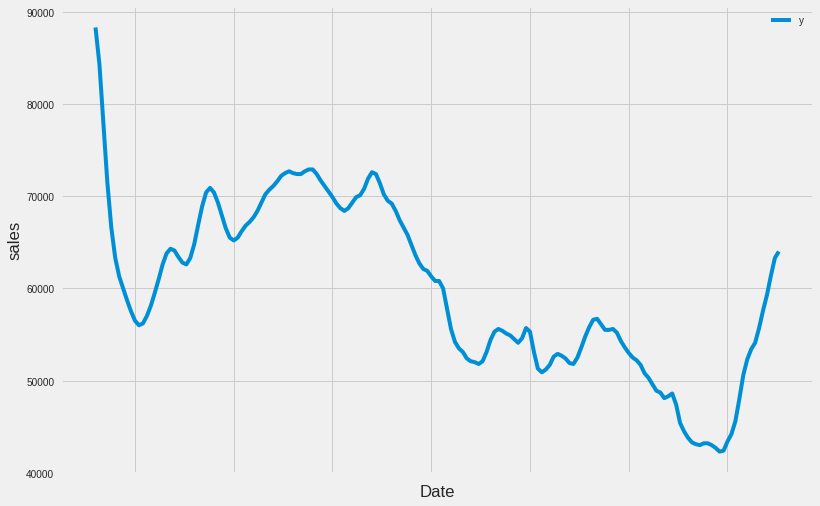

In [42]:
#Graph of Valdosta Time Series
ax = valdosta.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('sales')
ax.set_xlabel('Date')
plt.show()

In [43]:
# MODEL Valdosta
# Set the uncertainty interval to 95% (the Prophet default is 80%)

bev_model = Prophet(interval_width=0.95)
bev_model.fit(valdosta)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [48]:
future_dates = bev_model.make_future_dataframe(periods=2, freq='Y')
future_dates.tail()

,ds
261,2018-10-01
262,2018-11-01
263,2018-12-01
264,2018-12-31
265,2019-12-31


In [49]:
# MODEL Valdosta

forecast = bev_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
261,2018-10-01,48898.987680,38848.773382,59110.275205
262,2018-11-01,48926.088618,39311.121121,59648.727161
263,2018-12-01,48763.849369,39577.647223,58390.113603
264,2018-12-31,45588.330712,35606.168815,54664.820447
265,2019-12-31,44038.824838,34683.829218,54472.161565


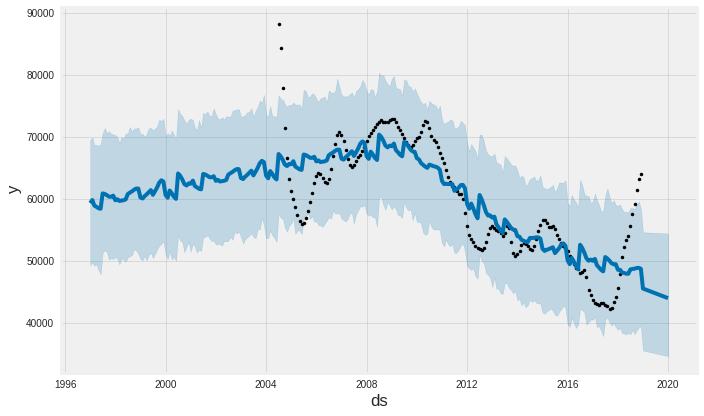

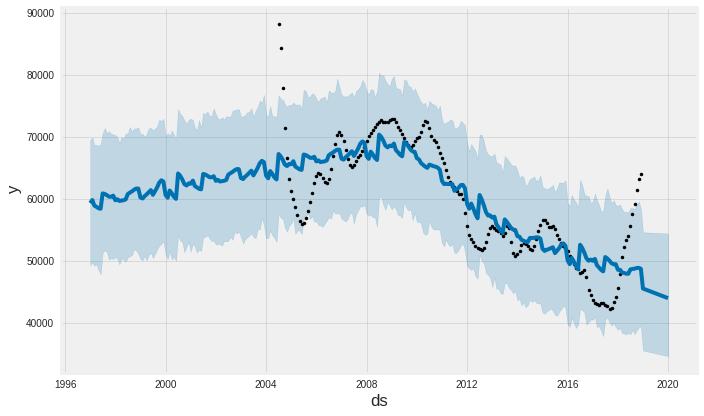

In [50]:
# MODEL Valdosta

bev_model.plot(forecast, uncertainty=True)

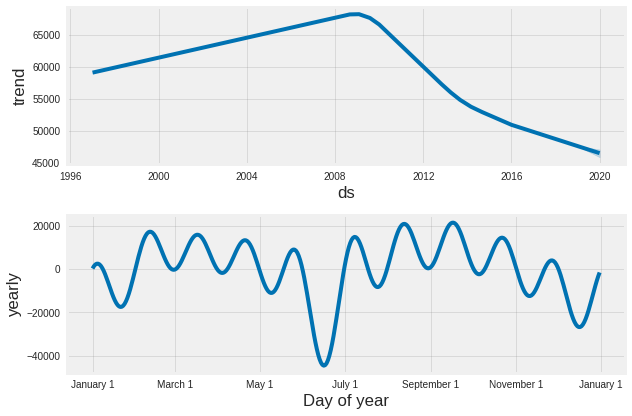

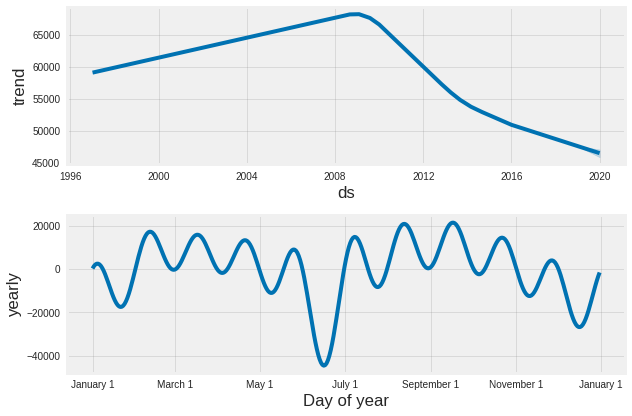

In [51]:
# INTERPRET Valdosta

bev_model.plot_components(forecast)


In [52]:
# Create dataframes for Macon in zipcodes for one year as that zipcode had the highest growth over a year
macon = (zipcode.loc[zipcode['RegionName'].isin(['31217'])])

# remove unwanted cols
macon = macon.drop(columns = ['RegionID','City','State','Metro','CountyName','SizeRank'])
# convert zip code to col names
macon = macon.set_index('RegionName')
# transpose time series matrices
macon = macon.T
# convert indices to date time
macon.index = pd.to_datetime(macon.index)
macon.head()

#Rename columns for prophet
macon = macon.rename(index=str, columns={"31601": "y", "RegionName": "ds"})
macon.head()

#Scrub - Thank you Beth!
macon =  macon[macon.columns[0]]
macon = pd.DataFrame(macon).reset_index()
macon.columns=['ds','y']
macon.head()

,ds,y
0,1997-01-01 00:00:00,49400.0
1,1997-02-01 00:00:00,49600.0
2,1997-03-01 00:00:00,49700.0
3,1997-04-01 00:00:00,49800.0
4,1997-05-01 00:00:00,49800.0


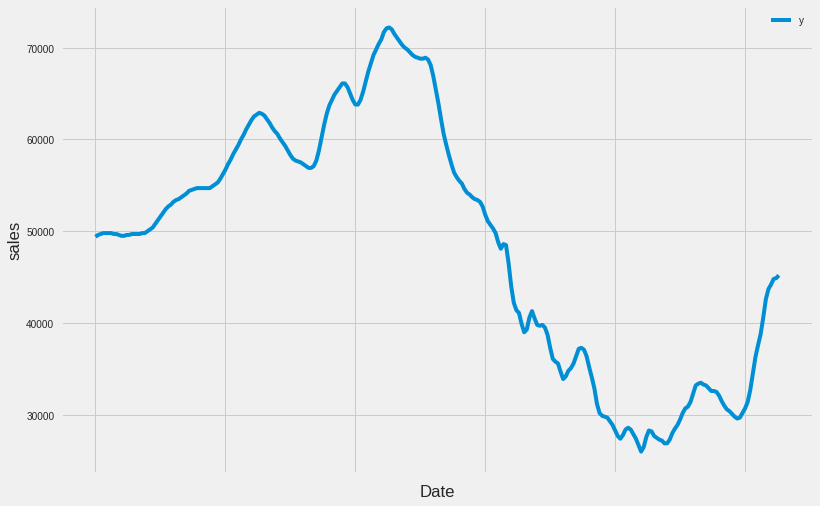

In [53]:
#Graph of Macon Time Series
ax = macon.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('sales')
ax.set_xlabel('Date')
plt.show()

In [56]:
# MODEL Macon
# Set the uncertainty interval to 95% (the Prophet default is 80%)

bev_model = Prophet(interval_width=0.95)
bev_model.fit(macon)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [57]:
# MODEL Macon

forecast = bev_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
261,2018-10-01,37965.109925,33797.371393,42193.528243
262,2018-11-01,38195.558005,33780.211253,42584.897199
263,2018-12-01,38400.288934,33607.129941,43138.572579
264,2018-12-31,37216.721397,33188.295924,41600.008609
265,2019-12-31,39565.603703,34314.107761,44384.338275


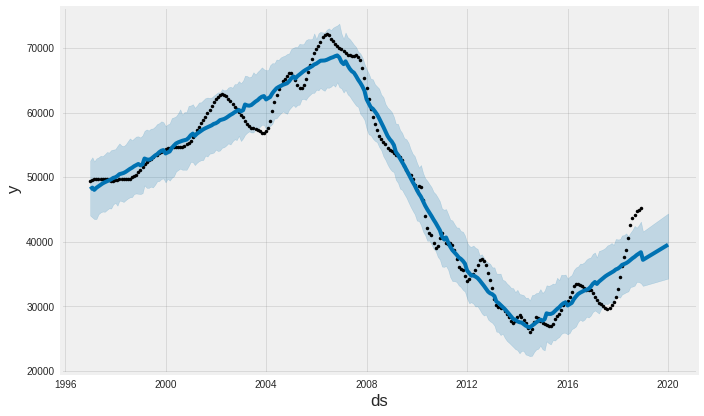

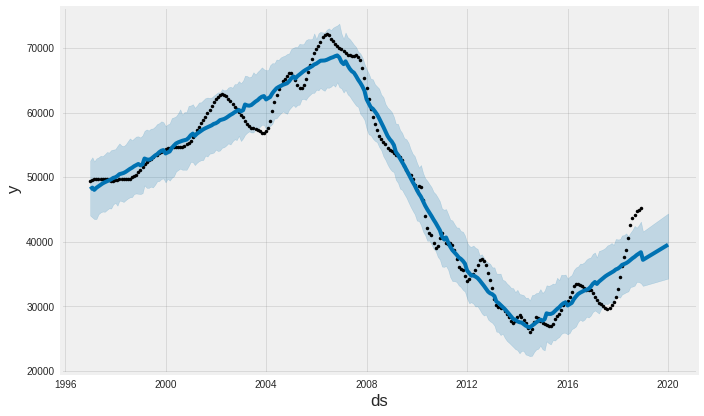

In [58]:
# MODEL Macon

bev_model.plot(forecast, uncertainty=True)

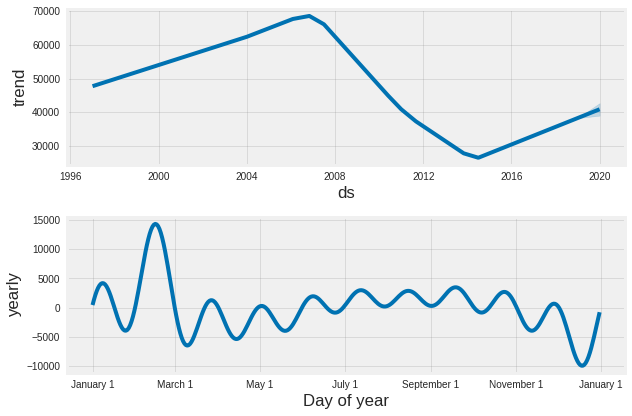

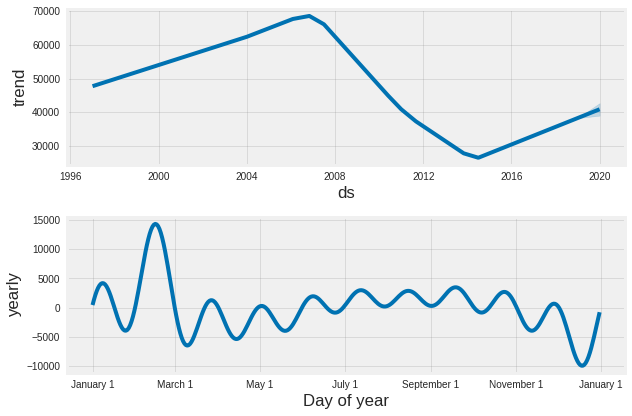

In [59]:
# INTERPRET Macon

bev_model.plot_components(forecast)

In [60]:
# Create dataframes for Columbus in zipcodes for one year as that zipcode had the highest growth over a year
columbus = (zipcode.loc[zipcode['RegionName'].isin(['31906'])])

# remove unwanted cols
columbus = columbus.drop(columns = ['RegionID','City','State','Metro','CountyName','SizeRank'])
# convert zip code to col names
columbus = columbus.set_index('RegionName')
# transpose time series matrices
columbus = columbus.T
# convert indices to date time
columbus.index = pd.to_datetime(columbus.index)
columbus.head()

#Rename columns for prophet
columbus = columbus.rename(index=str, columns={"31906": "y", "RegionName": "ds"})
columbus.head()

#Scrub - Thank you Beth!
columbus =  columbus[columbus.columns[0]]
columbus = pd.DataFrame(columbus).reset_index()
columbus.columns=['ds','y']
columbus.head()

,ds,y
0,1997-01-01 00:00:00,58700.0
1,1997-02-01 00:00:00,58800.0
2,1997-03-01 00:00:00,58900.0
3,1997-04-01 00:00:00,59100.0
4,1997-05-01 00:00:00,59100.0


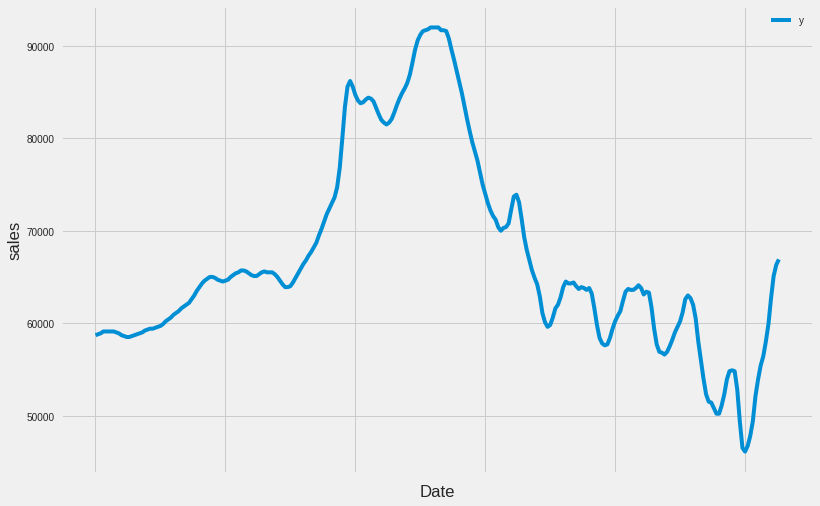

In [61]:
#Graph of Columbus Time Series
ax = columbus.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('sales')
ax.set_xlabel('Date')
plt.show()

In [62]:
# MODEL Columbus
# Set the uncertainty interval to 95% (the Prophet default is 80%)

bev_model = Prophet(interval_width=0.95)
bev_model.fit(columbus)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [63]:
# MODEL Columbus
future_dates = bev_model.make_future_dataframe(periods=2, freq='Y')
future_dates.tail()

,ds
261,2018-10-01
262,2018-11-01
263,2018-12-01
264,2018-12-31
265,2019-12-31


In [64]:
# MODEL Columbus

forecast = bev_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
261,2018-10-01,53740.848450,47062.705609,60405.955049
262,2018-11-01,53627.690499,46657.015987,59614.147636
263,2018-12-01,53666.697995,47475.346314,60103.656621
264,2018-12-31,53264.307365,46481.462835,60423.508710
265,2019-12-31,51912.001397,44682.740244,58451.806739


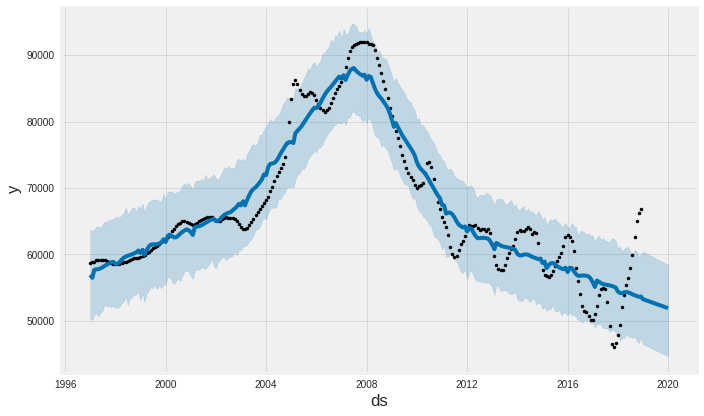

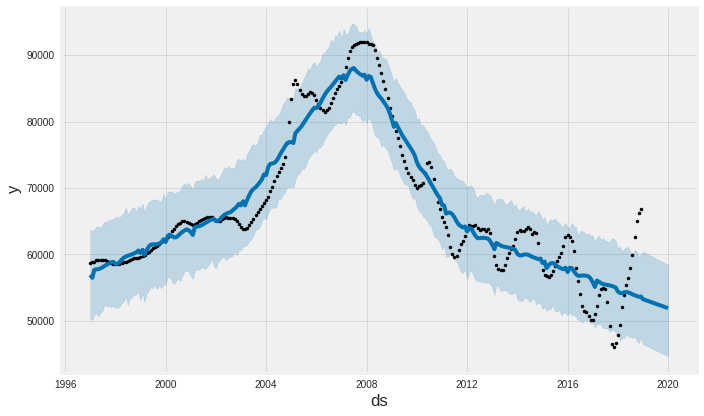

In [65]:
# MODEL Columbus

bev_model.plot(forecast, uncertainty=True)

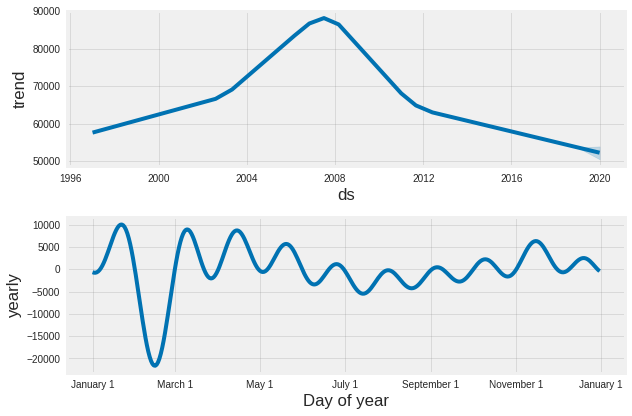

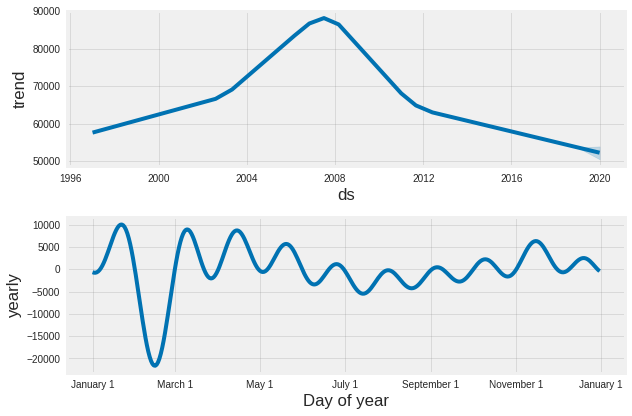

In [66]:
# INTERPRET Columbus

bev_model.plot_components(forecast)

In [68]:

# Create dataframes for Philly in zipcodes for one year as that zipcode had the highest growth over a year
phil = (zipcode.loc[zipcode['RegionName'].isin(['19146'])])

# remove unwanted cols
phil = phil.drop(columns = ['RegionID','City','State','Metro','CountyName','SizeRank'])
# convert zip code to col names
phil = phil.set_index('RegionName')
# transpose time series matrices
phil = phil.T
# convert indices to date time
phil.index = pd.to_datetime(phil.index)
phil.head()

#Rename columns for prophet
phil = phil.rename(index=str, columns={"31601": "y", "RegionName": "ds"})
phil.head()

#Scrub - Thank you Beth!
phil =  phil[phil.columns[0]]
phil = pd.DataFrame(phil).reset_index()
phil.columns=['ds','y']
phil.head()

,ds,y
0,1997-01-01 00:00:00,21400.0
1,1997-02-01 00:00:00,21100.0
2,1997-03-01 00:00:00,20800.0
3,1997-04-01 00:00:00,20600.0
4,1997-05-01 00:00:00,20400.0


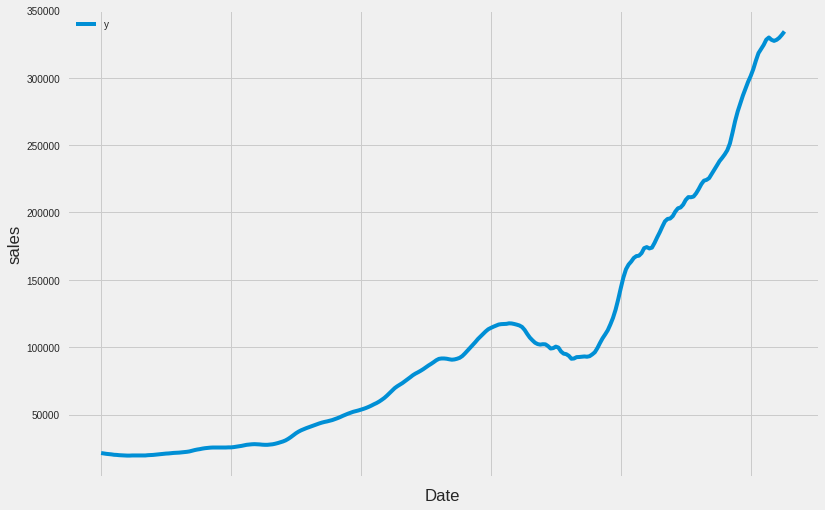

In [69]:
#Graph of Philly Time Series
ax = phil.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('sales')
ax.set_xlabel('Date')
plt.show()

In [70]:
# MODEL Philly
# Set the uncertainty interval to 95% (the Prophet default is 80%)

bev_model = Prophet(interval_width=0.95)
bev_model.fit(phil)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [71]:
# MODEL Philly
future_dates = bev_model.make_future_dataframe(periods=2, freq='Y')
future_dates.tail()

,ds
261,2018-10-01
262,2018-11-01
263,2018-12-01
264,2018-12-31
265,2019-12-31


In [72]:
# MODEL Philly

forecast = bev_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
261,2018-10-01,327684.426618,315099.262019,339568.508506
262,2018-11-01,331046.489201,319398.416947,343510.556758
263,2018-12-01,334095.594083,321722.638548,346192.754131
264,2018-12-31,335201.394874,323693.021035,347848.281324
265,2019-12-31,372892.146384,359144.741130,386325.046334


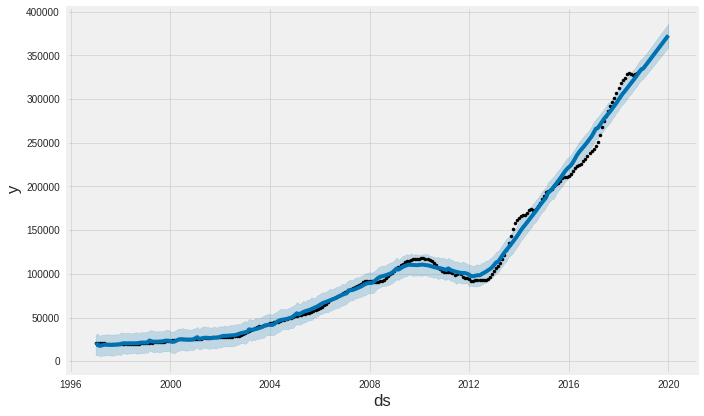

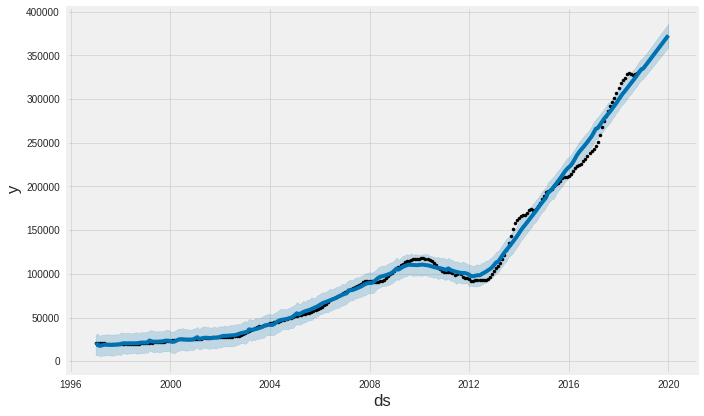

In [73]:
# MODEL Philly

bev_model.plot(forecast, uncertainty=True)

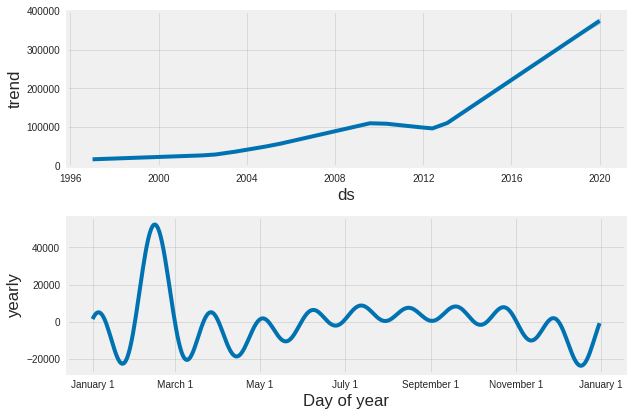

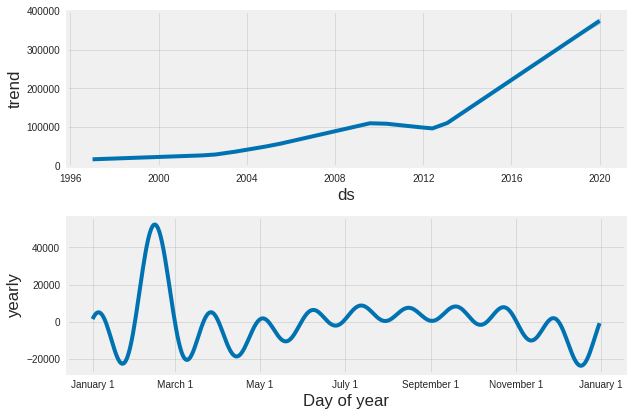

In [74]:
# INTERPRET Philly

bev_model.plot_components(forecast)